<a href="https://colab.research.google.com/github/sheethalkaran/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices/blob/main/Milestone3/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

!pip install prophet scikit-learn matplotlib seaborn --quiet

Mounted at /content/drive


In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [24]:
base_path = "/content/drive/MyDrive/FitPulse/Milestone_3_AnomalyDetection"
viz_path = f"{base_path}/visualizations"

os.makedirs(viz_path, exist_ok=True)

In [45]:
df = pd.read_csv(
    "/content/drive/MyDrive/FitPulse/Milestone2/data/milestone2_reduced_fitness_data.csv"
)

df["DateTime"] = pd.to_datetime(df["DateTime"]).dt.tz_localize(None)
df.head()

,DateTime,Id,HeartRate,Steps,TotalMinutesAsleep
0,2016-04-12 00:00:00,4020332650,63.500000,0,501.0
1,2016-04-12 00:01:00,4020332650,65.913043,0,501.0
2,2016-04-12 00:02:00,4020332650,67.000000,0,501.0
3,2016-04-12 00:03:00,4020332650,67.000000,0,501.0
4,2016-04-12 00:04:00,4020332650,67.000000,0,501.0


In [27]:
print(df.shape)

(75, 5)


In [47]:
hr_df = df[["DateTime", "HeartRate"]].rename(
    columns={"DateTime": "ds", "HeartRate": "y"}
)

model_hr = Prophet()
model_hr.fit(hr_df)

forecast_hr = model_hr.predict(hr_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [48]:
sleep_df = df[["DateTime", "TotalMinutesAsleep"]].rename(
    columns={"DateTime": "ds", "TotalMinutesAsleep": "y"}
)

model_sleep = Prophet()
model_sleep.fit(sleep_df)

forecast_sleep = model_sleep.predict(sleep_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [49]:
hr_df["predicted"] = forecast_hr["yhat"]
hr_df["residual"] = hr_df["y"] - hr_df["predicted"]

hr_threshold = 2 * hr_df["residual"].std()

hr_df["hr_anomaly"] = (
    (abs(hr_df["residual"]) > hr_threshold) |
    (hr_df["y"] < forecast_hr["yhat_lower"]) |
    (hr_df["y"] > forecast_hr["yhat_upper"])
)

In [50]:
sleep_df["predicted"] = forecast_sleep["yhat"]
sleep_df["residual"] = sleep_df["y"] - sleep_df["predicted"]

sleep_threshold = 2 * sleep_df["residual"].std()

sleep_df["sleep_anomaly"] = (
    (abs(sleep_df["residual"]) > sleep_threshold) |
    (sleep_df["y"] == 0)
)

In [51]:
agg_df = df.groupby("Id")[["HeartRate", "Steps", "TotalMinutesAsleep"]].mean()

scaler = StandardScaler()
scaled = scaler.fit_transform(agg_df)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled)

pca_df = pd.DataFrame(
    pca_features,
    columns=["PC1", "PC2"],
    index=agg_df.index
)

dbscan = DBSCAN(eps=1.5, min_samples=2)
pca_df["cluster_label"] = dbscan.fit_predict(pca_features)

pca_df["cluster_anomaly"] = pca_df["cluster_label"] == -1

In [52]:
df = df.merge(
    hr_df[["ds", "hr_anomaly"]],
    left_on="DateTime", right_on="ds", how="left"
)

df = df.merge(
    sleep_df[["ds", "sleep_anomaly"]],
    left_on="DateTime", right_on="ds", how="left"
)

df = df.merge(
    pca_df[["cluster_anomaly"]],
    left_on="Id", right_index=True, how="left"
)

df["final_anomaly"] = (
    df["hr_anomaly"] |
    df["sleep_anomaly"] |
    df["cluster_anomaly"]
)

df

,DateTime,Id,HeartRate,Steps,TotalMinutesAsleep,ds_x,hr_anomaly,ds_y,sleep_anomaly,cluster_anomaly,final_anomaly
0,2016-04-12 00:00:00,4020332650,63.500000,0,501.0,2016-04-12 00:00:00,False,2016-04-12 00:00:00,False,False,False
1,2016-04-12 00:01:00,4020332650,65.913043,0,501.0,2016-04-12 00:01:00,False,2016-04-12 00:01:00,False,False,False
2,2016-04-12 00:02:00,4020332650,67.000000,0,501.0,2016-04-12 00:02:00,False,2016-04-12 00:02:00,False,False,False
3,2016-04-12 00:03:00,4020332650,67.000000,0,501.0,2016-04-12 00:03:00,False,2016-04-12 00:03:00,False,False,False
4,2016-04-12 00:04:00,4020332650,67.000000,0,501.0,2016-04-12 00:04:00,False,2016-04-12 00:04:00,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
148,2016-04-17 05:40:00,2026352035,69.000000,0,437.0,2016-04-17 05:40:00,False,2016-04-17 05:40:00,False,False,False
149,2016-04-17 05:41:00,2026352035,67.800000,0,437.0,2016-04-17 05:41:00,False,2016-04-17 05:41:00,False,False,False
150,2016-04-17 05:42:00,2026352035,68.166667,0,437.0,2016-04-17 05:42:00,False,2016-04-17 05:42:00,False,False,False
151,2016-04-17 05:43:00,2026352035,68.000000,0,437.0,2016-04-17 05:43:00,False,2016-04-17 05:43:00,False,False,False


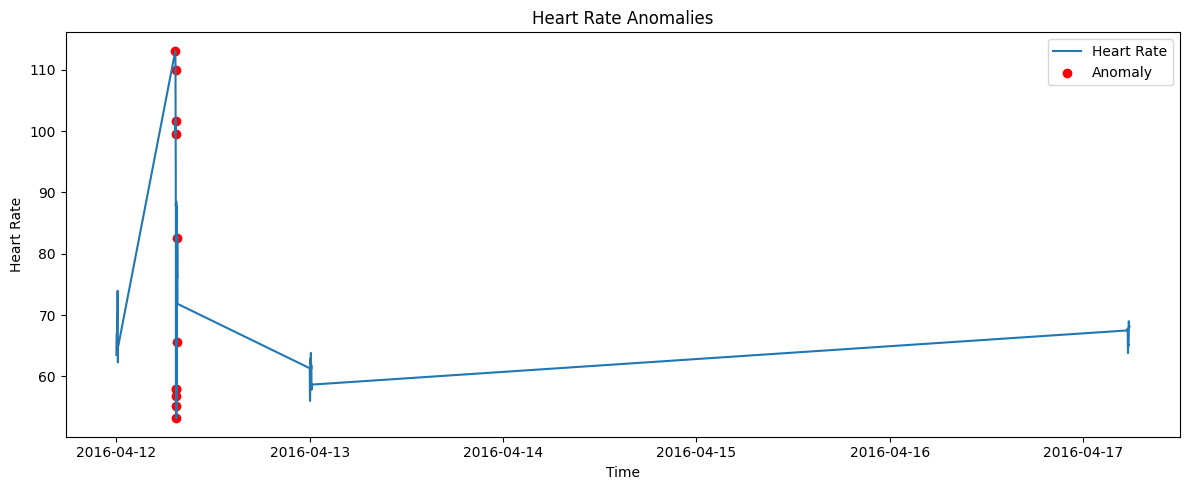

In [53]:
plt.figure(figsize=(12,5))
plt.plot(hr_df["ds"], hr_df["y"], label="Heart Rate")
plt.scatter(
    hr_df.loc[hr_df["hr_anomaly"], "ds"],
    hr_df.loc[hr_df["hr_anomaly"], "y"],
    color="red",
    label="Anomaly"
)
plt.title("Heart Rate Anomalies")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.legend()
plt.tight_layout()
plt.savefig(f"{viz_path}/heart_rate_anomalies.png")
plt.show()

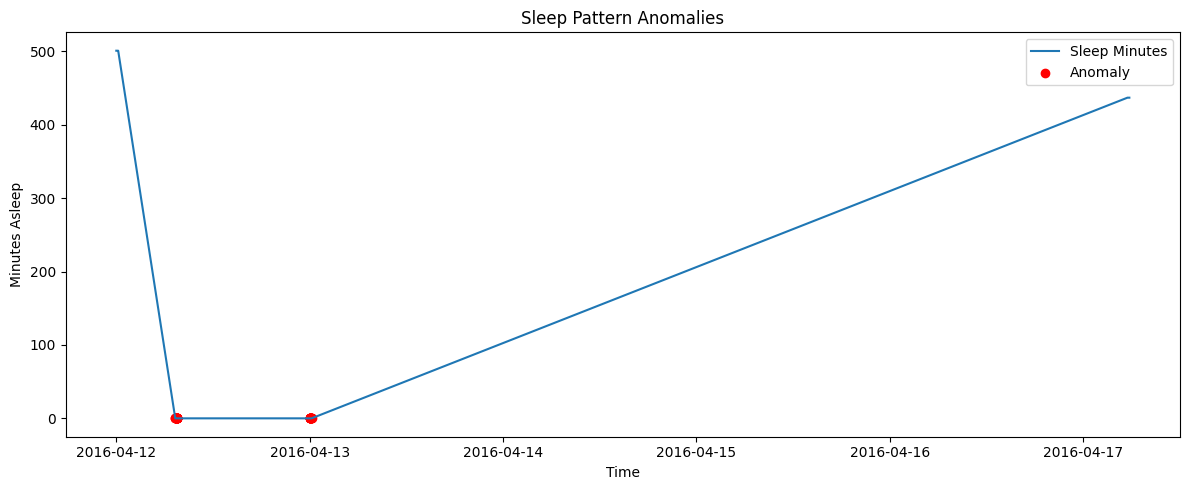

In [54]:
plt.figure(figsize=(12,5))
plt.plot(sleep_df["ds"], sleep_df["y"], label="Sleep Minutes")
plt.scatter(
    sleep_df.loc[sleep_df["sleep_anomaly"], "ds"],
    sleep_df.loc[sleep_df["sleep_anomaly"], "y"],
    color="red",
    label="Anomaly"
)
plt.title("Sleep Pattern Anomalies")
plt.xlabel("Time")
plt.ylabel("Minutes Asleep")
plt.legend()
plt.tight_layout()
plt.savefig(f"{viz_path}/sleep_anomalies.png")
plt.show()

In [55]:
df.to_csv(
    f"{base_path}/milestone3_labeled_dataset.csv",
    index=False
)